In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, exponweib
from scipy import stats

# 1. Introduction

Two classifiers were trained to predict malignant or benign tumor cells using [Breast Cancer Wisconsin (Diagnostic) Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Prognostic%29). The data set contains 30 numeric features derived from cell nucleui images of breast cells. The first 10 features were used to train Logistic Regression and k Nearest Neighbours classifier. f1 score was used to measure classifier performance and the number of misclassifications were examined using confusion matrix.


# 2. Exploratory Data Analysis

Breast cancer data is imported using scikit learn's built in data set.

The description of the data set states that there are *10 attributes*; these are:

1. Radius
2. Texture
3. Perimeter
4. Area
5. Smoothness
6. Compactness
7. Concavity
8. Concave Points
9. Symmetry
10. Fractal Dimension

The **mean, standard errror and worst/largest values of each attribute were computed**, making up the **30 numeric features** in this data set.

There is a **total of 569** instances and the target values are **malignant(0): 212  or benign(1): 357**.

A dataframe is constructed to facilitate analysis.

In [2]:
from sklearn.datasets import load_breast_cancer
bc_data = load_breast_cancer()

#create dataframe from data and add diagnosis values to dataframe
bc_df = pd.DataFrame(bc_data.data, columns = bc_data.feature_names)
bc_df['Diagnosis'] = bc_data.target #Malignant = 0, Benign = 1


### 2.1 How does each individual attribute contribute to diagnosis?

To examine the effect of each individual feature on diagnosis, a boxplot is plotted for each *mean* attribute to examine its distribution and outliers.

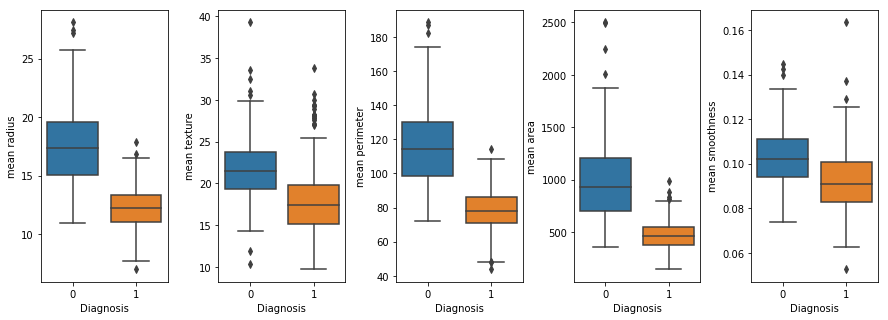

In [3]:
fig = plt.figure(figsize=(15,5)) #set figure size
fig.subplots_adjust(hspace=0.4, wspace=0.4) #adjust whitespace
for index,item in enumerate(bc_data.feature_names[0:5], start=1):
    plt.subplot(1, 5, index)
    sns.boxplot(x = bc_df["Diagnosis"], y = bc_df[item])


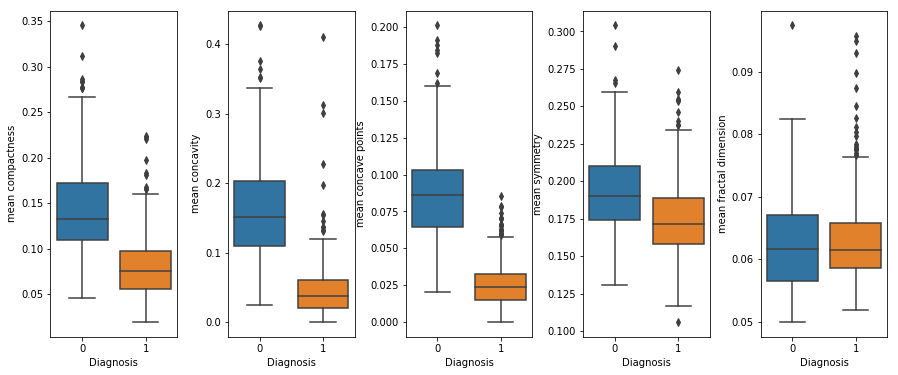

In [4]:
fig = plt.figure(figsize=(15,6)) #set figure size
fig.subplots_adjust(hspace=0.4, wspace=0.4) #adjust whitespace
for index,item in enumerate(bc_data.feature_names[5:10], start=1):
    plt.subplot(1, 5, index)
    sns.boxplot(x = bc_df["Diagnosis"], y = bc_df[item])

Malignant cells are plotted in blue and benign tumour cells are plotted in orange.

Benign tumor cells in general have smaller mean values than malignant tumor cells.

The plots above suggests that the mean values are well separated between malignant and benign tumor cells for *mean radius, mean parameter, mean area, mean compactness, mean convcavity and mean concave points*. Whereas, data point tends to overlap for *mean texture, mean smoothness, mean symmetry and mean fractal dimension*.

It is worth noting that there are outliers that tend to appear in the upper range of the values and it is worth bearing in mind that extreme outliers these can have significant effects on the model if they are included.

### 2.2 Are there any correlation between attributes?

To examine whether there are any correlations between these 10 attributes, scatter plots are created between each attributes.

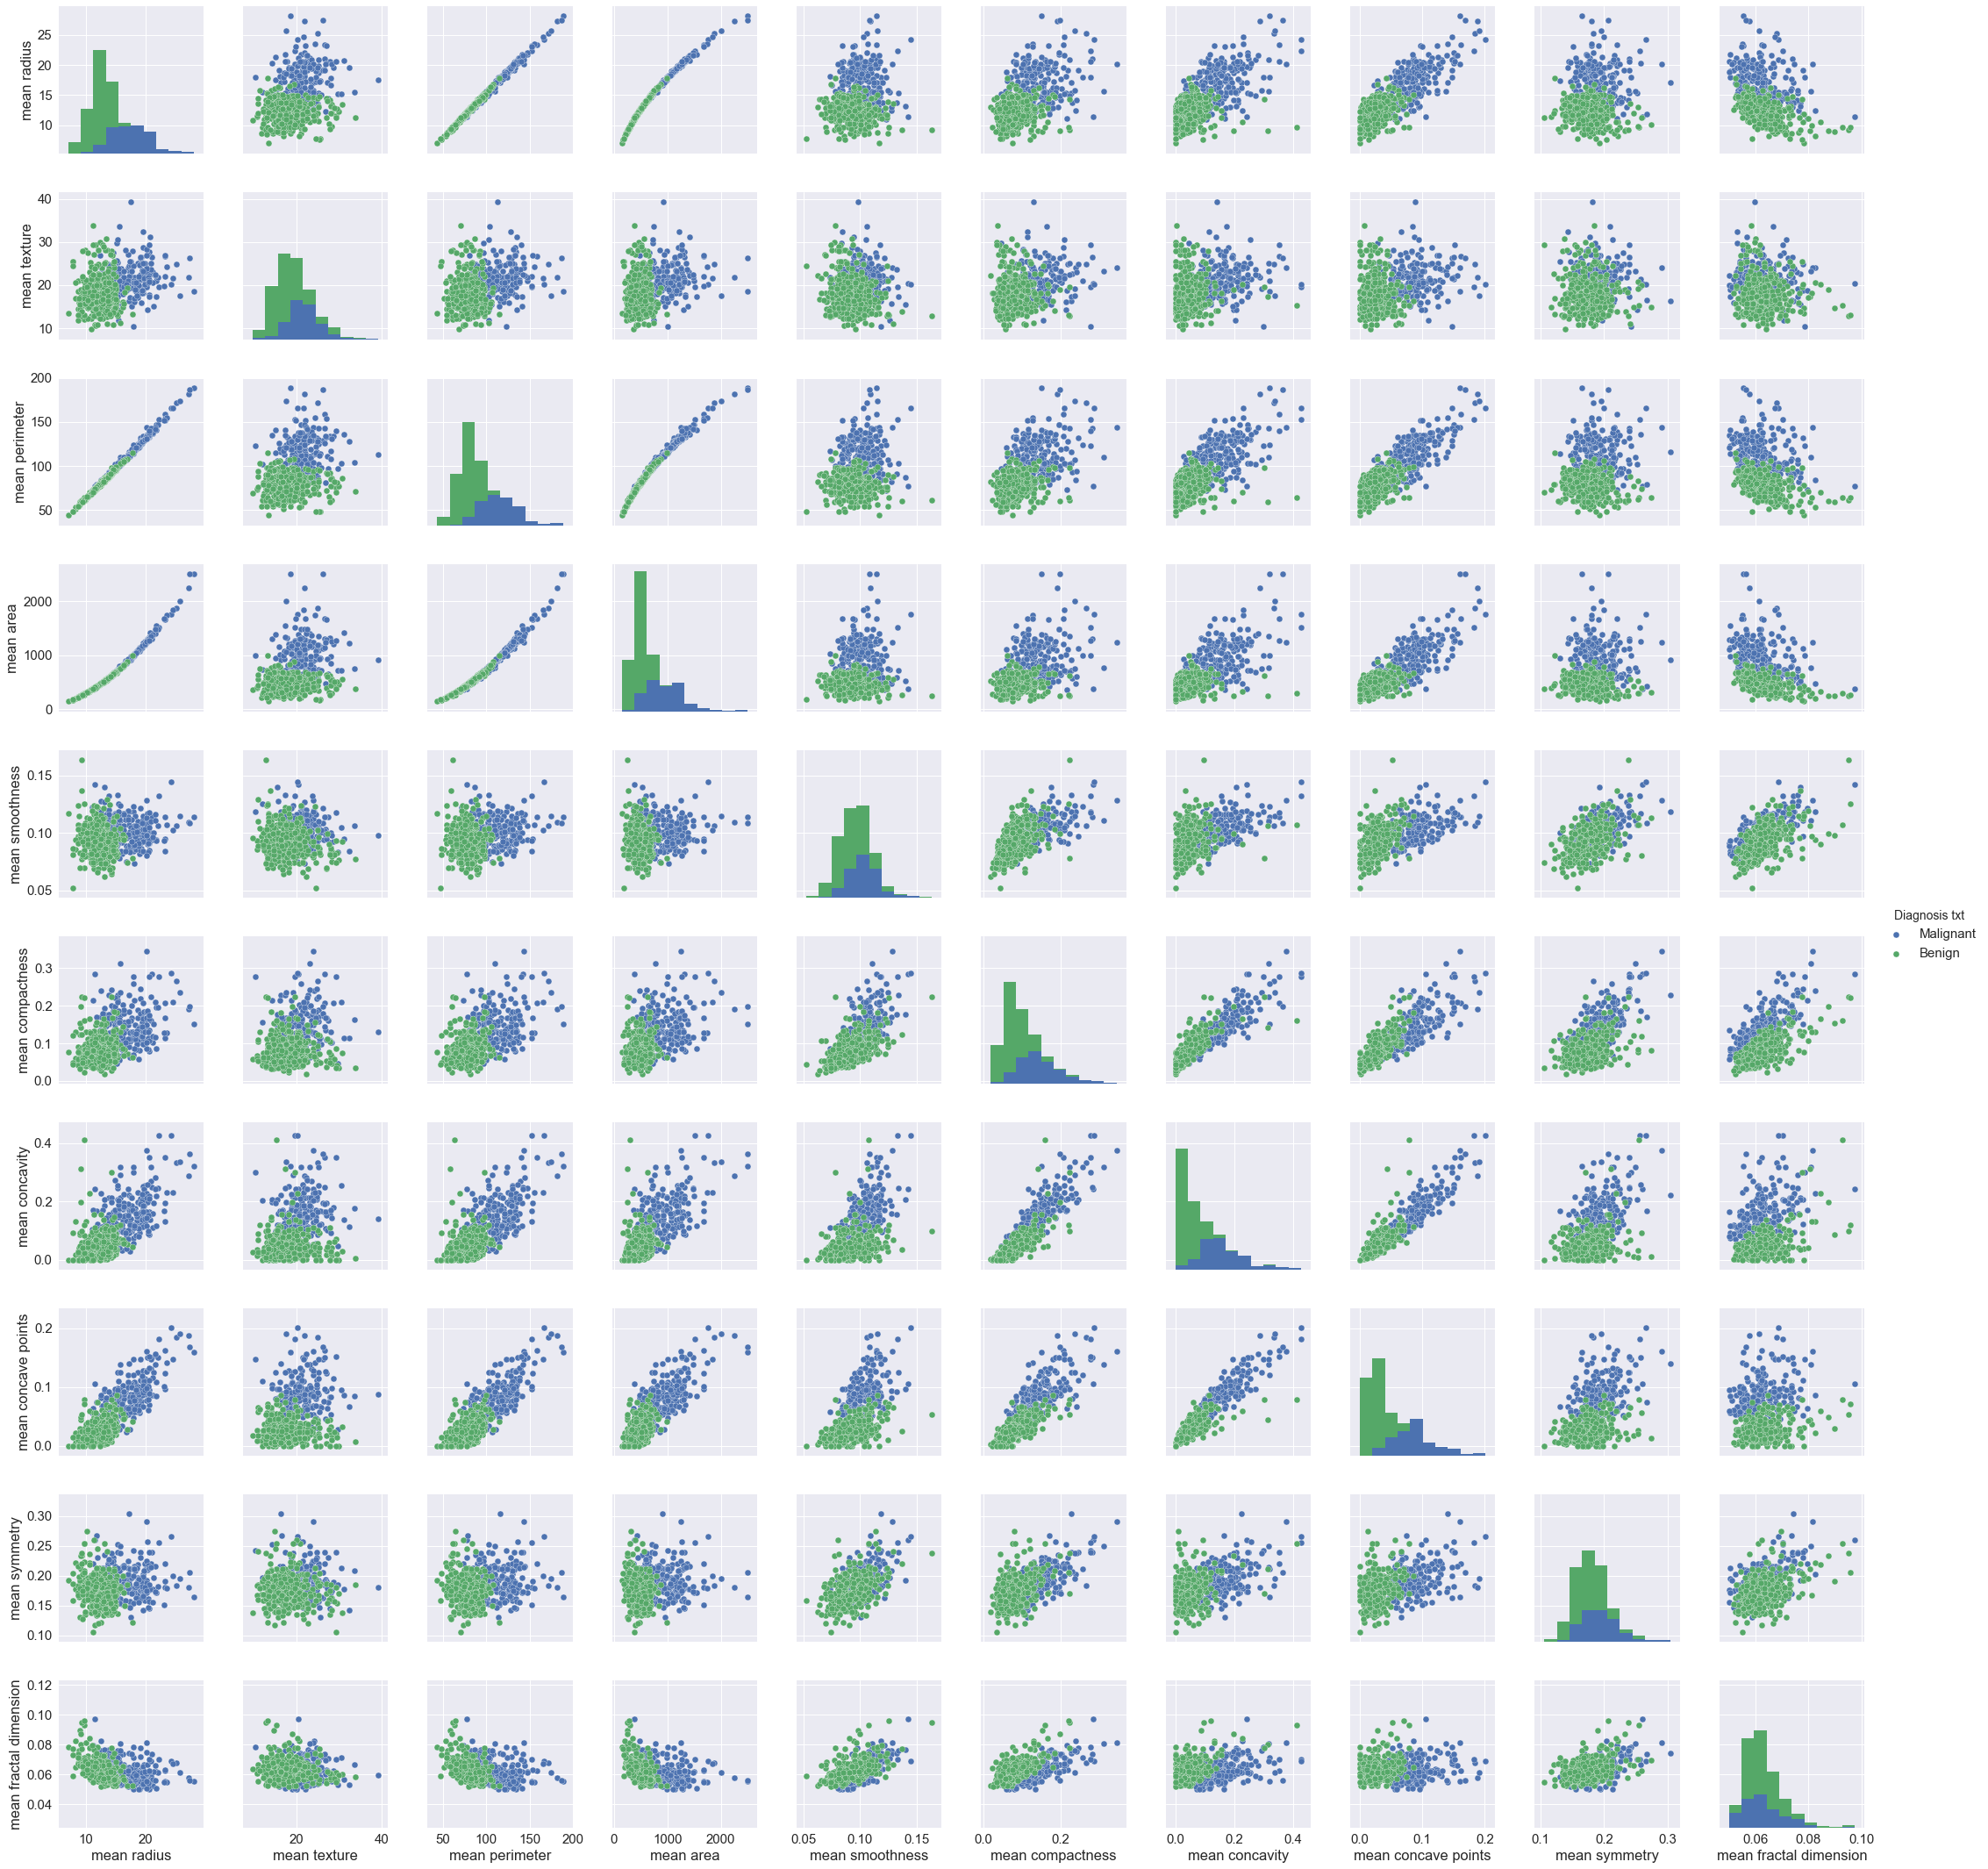

In [5]:
#create subset dataframe for pairplot
target_txt = np.empty(len(bc_df['Diagnosis']), dtype = object)
target_txt[bc_df['Diagnosis'] == 1 ] = 'Benign'
target_txt[bc_df['Diagnosis'] == 0 ] = 'Malignant'
bc_df['Diagnosis txt'] = target_txt

sub_df = bc_df.iloc[:,0:10].copy()
sub_df['Diagnosis txt'] = bc_df['Diagnosis txt']

sns.set(font_scale = 1.5)
sns.pairplot(sub_df,hue ='Diagnosis txt', size=3);

There are strong linear relationships between mean radius, mean perimeter and mean area. This is to be expected since  radius and perimeter are parameters that make up the area of the nuclei.

Mean compactness, mean concavity and mean concave points are also positively correlated.

It is important to bare in mind that strongly correlated features are not adding any more useful information to the model and hence, one of the features can be omitted or both can be combined into one feature.

### 2.3 What are the mean, median and standard deviation of the “perimeter (mean)” feature?

In [6]:
print ('The mean of Perimeter(mean) feature is', "%.2f" % np.mean(bc_df['mean perimeter']))
print ('The median of Perimeter(mean) feature is', "%.2f" % np.median(bc_df['mean perimeter']))
print ('The standard deviation of Perimeter(mean) feature is', "%.2f" % np.std(bc_df['mean perimeter']))

The mean of Perimeter(mean) feature is 91.97
The median of Perimeter(mean) feature is 86.24
The standard deviation of Perimeter(mean) feature is 24.28


### 2.4 Is the first feature in this data set (“radius (mean)”) normally distributed? 

To determine whether the mean Radius(mean) feature is normally distributed, we can first examine this visually, then quantify this using statistical tests.

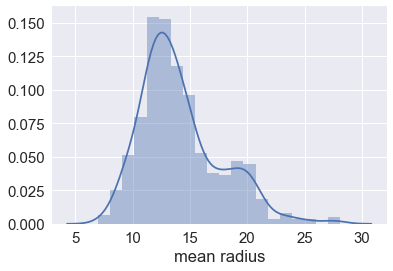

In [7]:
sns.distplot(bc_df['mean radius'], bins = 20);

The distribution plot above combines a histogram with kernel density estimation (KDE). It clearly shows the distribution is not normal and there seems to be two combined distributions. The following plot separates mean radius by the diagnosis outcome.

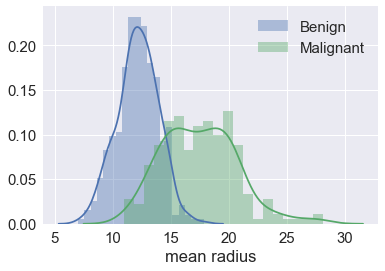

In [8]:
sns.distplot(bc_df[bc_df['Diagnosis']== 1]['mean radius'], label = 'Benign', bins= 20);
sns.distplot(bc_df[bc_df['Diagnosis']== 0]['mean radius'], label = 'Malignant', bins = 20);
plt.legend(loc = 'upper right');

Histogram of the same plot grouped by diagnosis outcome shows there are clearly two distributions.
The distribution of mean radius in benign cells looks normal, while for malignant cells, there are fewer data in the center than a normal curve which suggests there are signs of kurtosis.

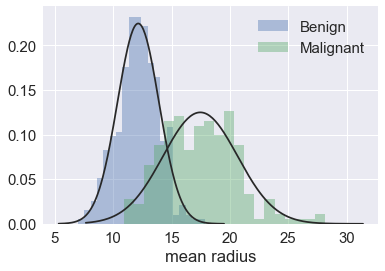

In [9]:
sns.distplot(bc_df[bc_df['Diagnosis']== 1]['mean radius'], label = 'Benign', fit=norm, kde=False, bins = 20);
sns.distplot(bc_df[bc_df['Diagnosis']== 0]['mean radius'], label = 'Malignant',fit=norm, kde=False, bins = 20);
plt.legend(loc = 'upper right');

Fitting the histograms with normal distribution clarifies the observation above.
Quantitative test for normal distribution using SciPy's normal test follows:

In [10]:
combined_k2, combined_p = stats.normaltest(bc_df['mean radius'])
B_k2, B_p = stats.normaltest(bc_df[bc_df['Diagnosis']== 1]['mean radius'])
M_k2, M_p = stats.normaltest(bc_df[bc_df['Diagnosis']== 0]['mean radius'])
print('Combined Diagnosis k2=',"%.2f" % combined_k2,'p-value =', "%.4f" %combined_p)
print('Benign k2=', "%.2f" % B_k2,'p-value =', "%.4f" %B_p)
print('Malignant k2=', "%.2f" % M_k2,'p-value =', "%.4f" %M_p)

Combined Diagnosis k2= 73.18 p-value = 0.0000
Benign k2= 0.43 p-value = 0.8047
Malignant k2= 9.77 p-value = 0.0075


The null hypothesis is that the radius(mean) comes from a normal distribution and if the p-value is very small (much smaller than 0.05), the null hypothesis can be rejected, meaning that both distributions of combined diagnosis and malignant data are not normally distributed.

The p-value for benign data is above 0.05 and so it can be concluded that the radius(mean) of benign diagnosis are likely to come from a normal distribution.

# 3. Classifiers to Determine Diagnosis

Two classifiers are trained to predict diagnosis of malignant or benign tumour cells.
These are:
1. Multiple Logistic Regression
2. K Nearest Neighbour(kNN)

One of the key objectives is to train a classifier so that it can provide accurate prediction on data that it has not seen encountered before. In order to do this, the data is split into training set and test set with a 70%:30% split. The training set will be used to build the classifier and the test set will be set aside to be used later on for model evaluation.

In [11]:
from sklearn.model_selection import train_test_split

cols = range(10)
X = bc_df.iloc[:,cols]
Y = bc_df['Diagnosis']

#split the data into training and test set, shuffle data and set proportion of class distribution to be the same in both test and training set.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y , test_size = 0.3, random_state = 10, shuffle = True, stratify = Y )

### 3.1 Multiple Logistic Regression
Logistic regression assumes a linear decision boundary using the logistic function. It uses maximum likelihood as the estimator of the coefficients.

The logistic regression model in scikit learn has a regularization parameter, C; where adjusting this number can tune the fitting so that the model is more or less flexible. To choose an appropriate value for C, GridSearchCV is used to identify the best performing C value out of a range of values. In the following model, the C value ranges from 0.0001 to 100.

To assess the model performance of each C value, f1 scoring is used as the metric and the best parameter is selected based in the highest f1 score. f1 score is a better metric to evaluate classification than accuracy alone as it takes into account both the correct and incorrect classifications. A score of 1 means all classifications are predicted correctly.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
LR = LogisticRegression()
param_grid = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
LR_gridsearchCV = GridSearchCV(LR, param_grid, scoring='f1', cv=10)
LR_gridsearchCV.fit(X_train, Y_train)
print('Average f1 score {:0.2f}'.format(LR_gridsearchCV.best_score_))
print('Best parameter selected', LR_gridsearchCV.best_params_)


Average f1 score 0.95
Best parameter selected {'C': 100}


Using GridSearchCV, the regularization parameter C performed best at 100 with an average f1 score of 0.95 over 10 folds of data.

### 3.2 K Nearest Neighbours
K Nearest Neighbours(kNN) is a non-parametric classifier; this means that it does not assume any relationship between the attributes(X) and classes(Y). Instead, it uses maximum likelihood as the estimator based on the classification of its nearest *k* neighbours. GridSearchCV will be used again to choose the best value for the number of neighbours *k*.

In [13]:
from sklearn.neighbors import KNeighborsClassifier
kNN_gridsearch = KNeighborsClassifier()
param_grid = {'n_neighbors':np.arange(1,20)}
kNN_gridsearchCV = GridSearchCV(kNN_gridsearch,param_grid, scoring='f1', cv=10)
kNN_gridsearchCV.fit(X_train,Y_train)

print('Average f1 score {:0.2f}'.format(kNN_gridsearchCV.best_score_))
print('Best parameter selected', kNN_gridsearchCV.best_params_)


Average f1 score 0.93
Best parameter selected {'n_neighbors': 15}


The best performance was when *k = 15*.
The performance of kNN is slightly worse than logistic regression with an average f1 score of 0.93.

### 3.3 Model Evaluation - Confusion Matrix

As this data set is used to classify malignant or benign tumour cells, it is important to look at the number of incorrect predictions in each class because a misclassification of malignant tumour as benign can result in patients not getting the correct treatment. Conversely, it is less detrimental for a patient if their benign cells were misclassified as malignant. Confusion matrix will be plotted for both classifiers to examine this in more detail.

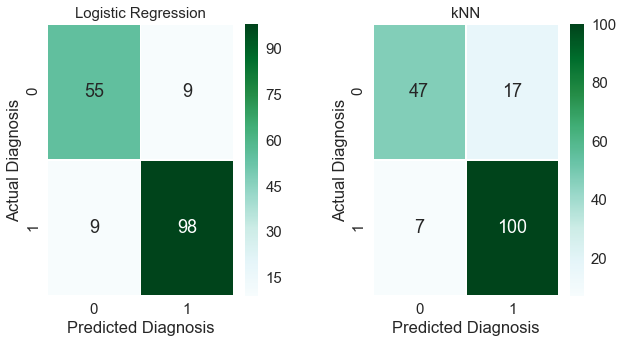

In [14]:
from sklearn.metrics import confusion_matrix
LR_predict = LR_gridsearchCV.predict(X_test)
LR_cmatrix = confusion_matrix(Y_test, LR_predict)

kNN_predict = kNN_gridsearchCV.predict(X_test)
kNN_cmatrix = confusion_matrix(Y_test,kNN_predict)

fig = plt.figure(figsize=(10,5)) #set figure size
fig.subplots_adjust(hspace=0.4, wspace=0.4) #adjust whitespace

#plot confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(LR_cmatrix, annot=True, fmt='0', linewidths=.5, cmap='BuGn');
plt.ylabel('Actual Diagnosis');
plt.xlabel('Predicted Diagnosis');
Title = 'Logistic Regression';
plt.title(Title, size = 15);

plt.subplot(1, 2, 2)
sns.heatmap(kNN_cmatrix, annot=True, fmt='0', linewidths=.5, cmap='BuGn');
plt.ylabel('Actual Diagnosis');
plt.xlabel('Predicted Diagnosis');
Title = 'kNN';
plt.title(Title, size = 15);

In this instance, both models have an overall low error rate of 9.9% and 14.0% for logistic regression and kNN respectively. As mentioned above, it is more important to classify all malignant (0) cases correctly and the error rates are much higher for the classification of malignant cells. In the logistic regression model, 9 out of 64 instances of malignant cells were missed (14.1%). As for kNN model, 17 out of 64 (26.6%) were missed.

# 4. Future Work

* **Fine tune decision threshold to reduce malignant cell misclassification** - The number of misclassfications of malignant cell as benign cells can be reduced by adjusting the decision threshold. However, a trade off is expected between the overall model accuracy and reducing malignant cell misclassification.

* **Feature selection in both Logistic Regression and kNN classifiers** - In both classifiers, the first 10 features were used for training. Performance may be improved by reducing the number of features or creating new features such as polynomials of existing features. For logistic regression, the p-value of the coefficients will be useful to determine whether there is a relationship between a feature and the diagnosis; the standard error of the coefficients can be used to determine the accuracy of the effect.

* **Train other classifiers such as SVC, Decision Tree** - large margin classifier or decision tree may improve performance, but the results will be less interpretable than regression models. 